[Document](https://viblo.asia/p/pyspark-voi-mot-project-machine-learning-nho-nho-3RlL5GyB4bB)

In [1]:
!pip install pyspark
!pip install pandas
!pip install openpyxl
!pip install matplotlib
!pip install seaborn

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("Online Retail").getOrCreate()

23/11/05 10:00:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Convert file xlxs to csv
read_file = pd.read_excel("../data/online_retail.xlsx")
read_file.to_csv("../data/online_retail.csv", index=None, header=True)

KeyboardInterrupt: 

In [4]:
# Read csv data
df = pd.DataFrame(pd.read_csv("online_retail.csv"))
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [6]:
df = spark.read.csv("online_retail.csv", inferSchema=True, header=True)

In [11]:
df.where(col("InvoiceNo").startswith("C")).count()

9288

In [82]:
df = df.select("*").filter(~col("InvoiceNo").startswith("C"))

In [83]:
# Amount of data 
df.count()

532621

In [20]:
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [21]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [22]:
# Amount of customers
df.select("CustomerID").distinct().count()

4373

In [28]:
# Count customers based on country
df.groupBy("Country").agg(countDistinct("CustomerID").alias("country_count")).orderBy(desc("country_count")).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [84]:
# Convert column InvoiceDate to timestamp
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn("date", to_timestamp("InvoiceDate", "yy-MM-dd HH:mm:ss"))
df.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|               date|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingd

In [45]:
# The first day of order
df.select(min("date")).show()

# The lately order
df.select(max("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



<h3>Pre-processing data</h4>

<h4>Recency</h4>

In [85]:
# New column with name 'from_date', all the values is the first day of orders
first_day = df.select(min("date")).first()[0]
df = df.withColumn("from_date", lit(first_day)) # Use lit to add a new column with a constant value

In [86]:
# Calculate purchase time by 'date' minus 'from_date', the value store with column 'recency'
df = df.withColumn("from_date", to_timestamp("from_date", "yy-MM-dd HH:mm"))
df2 = df.withColumn("from_date", to_timestamp(col("from_date"))).withColumn("recency", col("date").cast("long") - col("from_date").cast("long"))

In [87]:
# Update column 'recency' with the latest time depend on customer
df2 = df2.join(df2.groupBy("CustomerID").agg(max("recency").alias("recency")), on="recency", how="leftsemi")

<h4>Frequency</h4>

In [88]:
# Calculate frequency base on the amount of order
df_freq = df2.groupBy("CustomerID").agg(count("InVoiceNo").alias("frequency"))

In [89]:
# Join to main dataframe
df3 = df2.join(df_freq,on='CustomerID',how='inner')

<h4>Monetary</h4>

In [97]:
# Calculate how much money each customer spent
# Calculate total amount for each order
val = df3.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))

In [98]:
# Total money customer spent on
val = val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [99]:
# Join data
final_df = val.join(df3,on='CustomerID',how='inner')

In [100]:
final_df.show()

+----------+------------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID|    monetary_value|recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+------------------+-------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   16858.0|375.69000000000005| 437160|   537236|    85048|15CM CHRISTMAS GL...|       4|2010-12-06 09:52:00|     7.95|United Kingdom|2010-12-06 09:52:00|2010-12-01 08:26:00|       10|
|   16858.0|375.69000000000005| 437160|   537236|    48184|DOORMAT ENGLISH R...|       3|2010-12-06 09:52:00|     7.95|United Kingdom|2010-12-06 09:52:00|2010-12-01 08:26:00|       10|
|   16858.0|375.69000000000005| 437160|   537236|    21531|RED RETROSPOT SU

In [101]:
# Only take necessary field
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()
final_df.show()

+--------+---------+------------------+----------+
| recency|frequency|    monetary_value|CustomerID|
+--------+---------+------------------+----------+
| 4242300|        1| 76.32000000000001|   14090.0|
| 1058760|        6|             145.0|   17524.0|
| 1754220|       16|             383.7|   12515.0|
|  707820|       74| 372.0900000000001|   16065.0|
|13662900|       37|             570.2|   13975.0|
|24122700|        4|              64.8|   15462.0|
|22386000|       14|            224.13|   16092.0|
|28531620|       32|236.09000000000006|   16026.0|
|26697540|        9|            312.98|   13845.0|
|27662940|       35|            151.83|   16412.0|
|28946880|       12|             151.3|   13697.0|
|28784460|       40|168.10000000000005|   14179.0|
|30774480|        1|59.400000000000006|   14768.0|
|30091920|       86|484.37999999999977|   16504.0|
|30703440|        1|              29.5|   15132.0|
|29821260|       51|1076.9400000000005|   12598.0|
|30066240|        3|           

<h3>Standardized data</h3>

In [103]:
assemble = VectorAssembler(
    inputCols=['recency','frequency','monetary_value'],
    outputCol='features'
)

assembled_data = assemble.transform(final_df)

scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

In [104]:
data_scale_output.select("standardized").show(2, truncate=False)

+---------------------------------------------------------------+
|standardized                                                   |
+---------------------------------------------------------------+
|[0.48879298610190786,0.025241515952002073,0.027235864310456076]|
|[0.12198912428759304,0.15144909571201243,0.051745287277465024] |
+---------------------------------------------------------------+
only showing top 2 rows



<h3>Machine Learning</h3>

In [106]:
# Find the number of clusters k
cost = np.zeros(10)
evaluator = ClusteringEvaluator(
    predictionCol='prediction',
    featuresCol='standardized',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

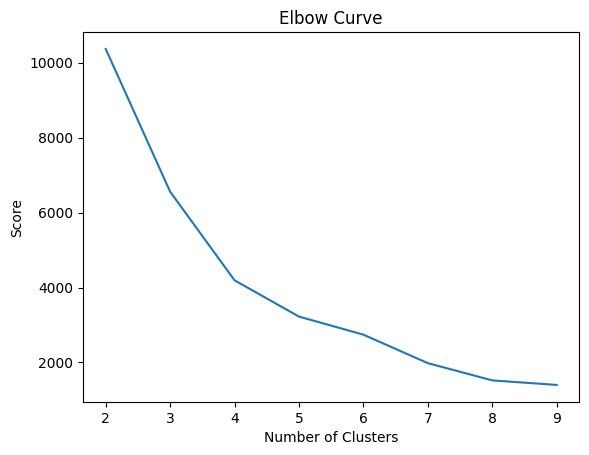

In [113]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [114]:
# Training K-means
kmeans_algo=KMeans(featuresCol='standardized', k=3)
kmeans_fit=kmeans_algo.fit(data_scale_output)

In [115]:
# Prediction
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)

+--------+---------+-----------------+----------+--------------------+--------------------+----------+
| recency|frequency|   monetary_value|CustomerID|            features|        standardized|prediction|
+--------+---------+-----------------+----------+--------------------+--------------------+----------+
| 4242300|        1|76.32000000000001|   14090.0|[4242300.0,1.0,76...|[0.48879298610190...|         1|
| 1058760|        6|            145.0|   17524.0|[1058760.0,6.0,14...|[0.12198912428759...|         1|
| 1754220|       16|            383.7|   12515.0|[1754220.0,16.0,3...|[0.20211923533924...|         1|
|  707820|       74|372.0900000000001|   16065.0|[707820.0,74.0,37...|[0.08155421620881...|         1|
|13662900|       37|            570.2|   13975.0|[1.36629E7,37.0,5...|[1.57422381486734...|         1|
+--------+---------+-----------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



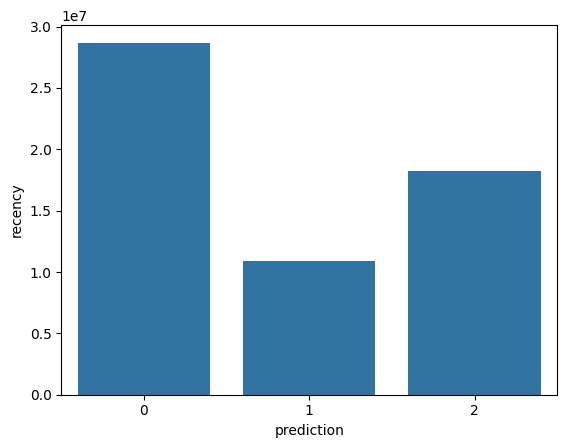

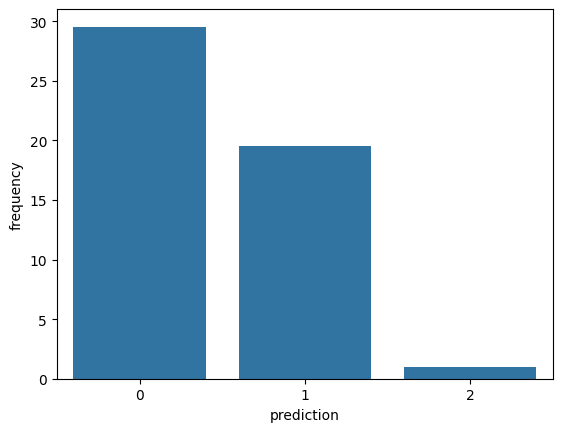

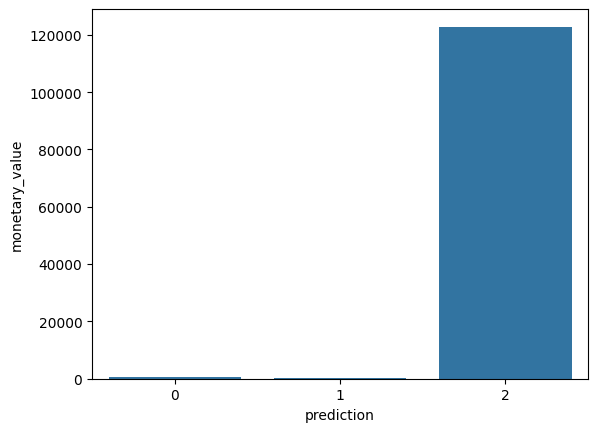

In [119]:
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()